# Stabilized ICA for transcriptomic data   

In this jupyter notebook, we propose a short example for the use of our stabilized ICA algorithm. We study the extraction of ICA components for a transcriptomic data set gathering NSCLC patients.   

**Note :** To run this jupyter notebook, you first need to extract the data set "data.csv" from the zip file "data.zip" (same directory)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## 0. Load the data set

This data set was extraced from ["Defining the Biological Basis of Radiomic Phenotypes in Lung Cancer" Grossman et al. 2017](https://elifesciences.org/articles/23421).   
It contains the expression of 21,766 unique genes for 269 patients with Non-small cell lung cancer (NSCLC) treated at the H. Lee Moffitt Cancer Center, Tampa, Florida, USA. Gene expression values were measured on a custom Rosetta/Merck Affymetrix 2.0 microarray chipset and normalized with the robust multi-array average (RMA) algorithm.

In [2]:
df = pd.read_csv("data.csv" , index_col=0).T
df.head()

,RadioGenomic-017,RadioGenomic-055,RadioGenomic-227,RadioGenomic-222,RadioGenomic-212,RadioGenomic-191,RadioGenomic-259,RadioGenomic-110,RadioGenomic-003,RadioGenomic-034,...,RadioGenomic-261,RadioGenomic-204,RadioGenomic-084,RadioGenomic-232,RadioGenomic-049,RadioGenomic-186,RadioGenomic-134,RadioGenomic-239,RadioGenomic-162,RadioGenomic-179
3643,5.205151,5.615738,5.679276,5.317341,7.196904,5.405730,5.218404,5.607431,6.544434,5.848995,...,5.115181,5.732982,5.713161,5.922955,5.796744,5.620590,5.435381,7.151574,6.706473,6.536985
84263,7.097989,6.585052,7.747854,7.196276,9.346492,7.662668,7.438435,8.463022,7.952210,7.936425,...,7.855756,7.651911,7.621733,7.889039,8.413899,8.264302,7.346372,7.480408,7.967057,7.924989
7171,9.559617,9.777869,10.648704,10.949771,9.673778,10.668188,9.227177,9.696762,10.185486,10.049003,...,9.742841,10.102686,9.533121,11.825210,10.096616,10.297810,10.160288,10.145422,8.893938,11.080574
2934,8.396808,9.082415,9.127985,8.098896,9.358636,8.421808,8.643859,8.445746,9.233013,9.350872,...,7.504968,7.035265,8.551597,8.271226,6.998375,9.346116,8.283634,7.095790,8.356098,8.978290
11052,7.603719,8.639498,7.369421,7.639882,8.741693,8.306786,6.706823,6.024337,6.840010,8.427551,...,6.497460,8.156322,8.075888,7.541231,8.135110,7.826186,7.820982,6.427032,8.622156,7.127454


**Note :** in the following step, we center the expression of each gene (i.e the rows of the dataframe df). Indeed, we noticed that omitting this pre-processing step led to one ICA component entirely driven by the differences between the  mean expression of each gene. This component is not biologically relevant and we avoid it thanks to this centering step.

In [3]:
X = df.apply(func = lambda x : x - x.mean() , axis = 1)

## 1. Most Stable Transcriptome Dimension (MSTD)   

In order to select the number of ICA components we refer to ["Determining the optimal number of independent components for reproducible transcriptomic data analysis" Kairov et al. 2017](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-017-4112-9). The idea is to find a trade-off between a sufficiently large number of components to capture all essential information and a restricted dimension to avoid ending up with a lot of very unstable components which only capture noise.   

To do so we plot the stability distribution for a wide range of different number of components M = 5, ... , 100 and we observe which choice of M most satisfies the trade-off.

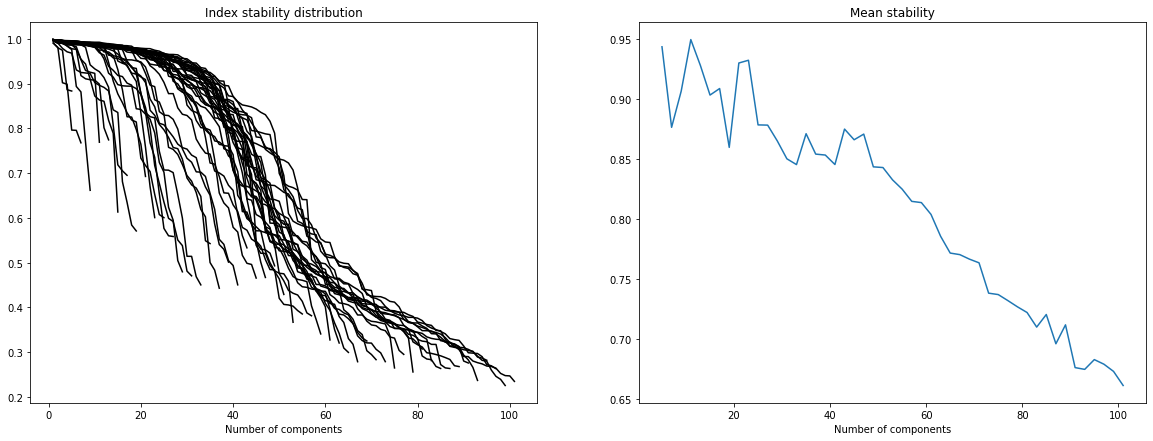

In [12]:
from sica.base import MSTD
MSTD(X.values , m = 5 , M = 100 , step = 2 , n_runs = 20 , max_iter = 2000)

Please note that in the following we use a rough estimation of the optimal dimension (observed thanks to the graphs above). In fact more sophisticated techniques can be applied to estimate this dimension (ex: two-lines clustering) ; these can be found in the article cited above.

In [4]:
dim_opt = 45

## 2. Stabilized ICA and Multidimensional Scaling (MDS)   

This stabilized ICA algorithm is a copy of the ICASSO algorithm (implemented in MATLAB) (["ICASSO: software for investigating the reliability of ICA estimates by clustering and visualization" Himber et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/Himberg03.pd) The main idea is to iterate several times the FastICA algorithm (ex: from sklearn), cluster the results (agglomerative hierarchical clustering) and define the final ICA components as the centrotype of each cluster.   

Some explanation for Multidimensional Scaling can be found on the sklearn page : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html 

In [5]:
from sica.base import StabilizedICA 

running time (min): 00:37.35


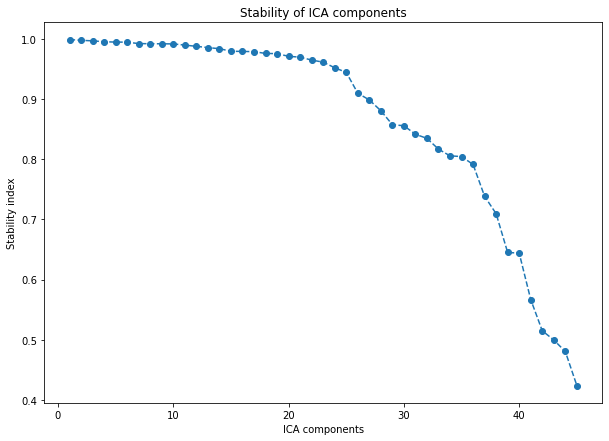

In [6]:
start = time.time()

sICA = StabilizedICA(n_components = dim_opt , max_iter = 2000 , n_jobs = -1)
sICA.fit(X , n_runs = 30 , plot = True ,normalize = True)

end = time.time()

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

running time (min): 00:30.90


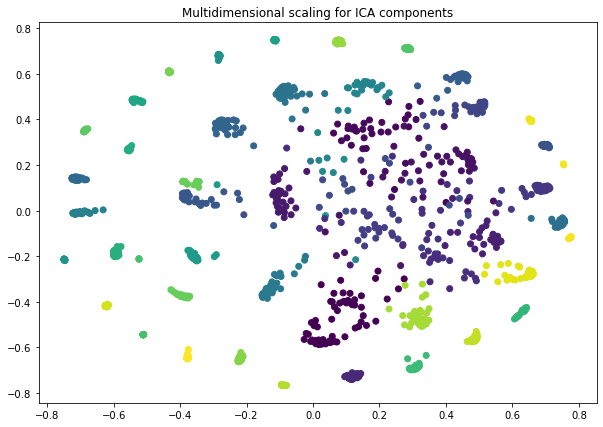

In [7]:
fig , ax = plt.subplots(figsize = (10 , 7))

start = time.time()

sICA.projection(ax = ax , method = 'mds')
ax.set_title("Multidimensional scaling for ICA components")

end = time.time() 

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

**Note :** by default, each stabilized ICA component (i.e a row of the S_ matrix) is normalized to unit variance and re-oriented towards positive heaviest tail. These operations facilitate the interpretation of the components and allow us to compare several components from different studies.

In [8]:
Metagenes = pd.DataFrame(sICA.S_ , columns = df.index , index = ['metagene ' + str(i) for i in range(sICA.S_.shape[0])])
Metagenes.head()

,3643,84263,7171,2934,11052,1241,6453,57541,9349,11165,...,643669,1572,8551,26784,26783,26782,26779,26778,26777,100132941
metagene 0,-0.585015,0.059987,0.616398,-0.653933,-0.058778,-0.540531,0.027365,0.218219,-0.403742,0.132285,...,0.150217,-0.373876,-1.048282,-0.095436,0.285986,0.109535,-0.667697,-0.192433,-0.030610,-0.300510
metagene 1,0.468769,-0.139593,-0.148511,0.467055,0.286536,0.702981,0.423193,-0.442603,0.715647,0.027159,...,-0.297743,3.193943,-0.139223,-0.171405,-0.330986,-0.158762,-0.452667,0.218287,0.320243,-0.014619
metagene 2,-0.686983,-0.223989,0.132187,0.013467,1.312197,0.185311,-0.269831,-0.110487,-2.322295,0.888115,...,-0.621915,-0.786544,-0.471800,0.008818,0.132042,1.616107,0.439376,0.663663,-0.043595,-0.381889
metagene 3,-0.043496,0.037644,0.544869,1.385100,-0.326644,2.431140,3.477954,0.334374,-1.230890,1.385647,...,0.640201,0.361540,0.612929,-1.481600,-1.078207,0.430936,0.686894,-0.641901,-0.368606,-0.784059
metagene 4,0.698661,-0.799123,1.542141,0.487279,0.129877,0.097255,1.502321,-0.389956,0.225269,0.296407,...,-0.719273,0.239641,-0.019394,0.425542,0.351399,0.094625,-0.458266,0.364036,-0.083407,-0.058183


We can check that we do obtain sparse ICA components by plotting the distribution of "metagene 1" values (i.e the coefficients associated with "metagene 1" for each feature)

Text(0, 0.5, 'Frequency')

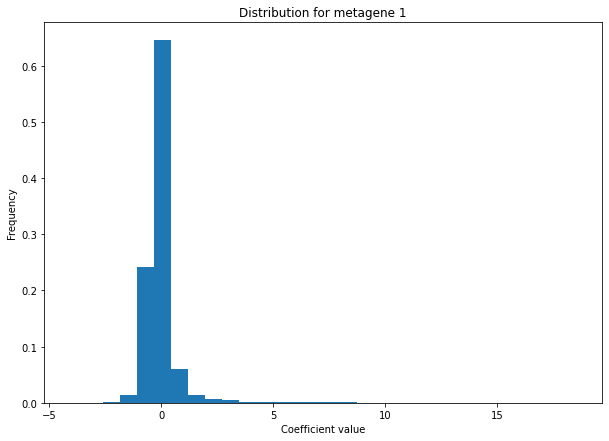

In [9]:
def distribution(Components ,  name , bins):  
    s = Components.loc[name]
    s.hist(bins = bins , weights=np.zeros_like(s) + 1. / s.size , grid = False)
    return

plt.figure(figsize = (10 , 7))
distribution(Metagenes , name = 'metagene 1' , bins = 30)
plt.title("Distribution for metagene 1")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")

## 3. Metagene annotation with reactome enrichment analysis

Finally, we provide a tool to perform enrichment analysis and characterize each metagene with relevant biological pathways from the [reactome database](https://reactome.org/). This tool gathers two major operations : 
- For each metagene a list of the most expressed genes is retrieved.
- An enrichment analysis (hypergeometric test) is performed on this list using the reactome pathways.

**Note :** This tool is based on the python package [reactome2py](https://pypi.org/project/reactome2py/).

In [10]:
from sica.annotate import ReactomeAnalysis

The user can choose different strategies for selecting the most expressed genes of each metagene :
- He can choose to only look at the right tail of the metagene distribution, the left tail, both or the heaviest one.
- He can choose whether the thresholds will be computed with deviations from the mean of the distribution (i.e $\mu \pm k*\sigma$) or with its quantiles.
- He can fine tune these thresholds with the threshold parameter.

In [11]:
annotations = ReactomeAnalysis(data = Metagenes , threshold = 0.01 , method = 'quantile' , tail = 'heaviest')

**Note :** By default, an arbitrary threshold of 0.05 is used to filter Entities pValue. The user can change it with the p_value parameter. The user can also pass a list of species to filter the results and a min and a max thresholds for the number of entities per pathway.

In [18]:
annotations.get_analysis(metagene = 'metagene 7' , species = 'Homo sapiens')

,Pathway identifier,Pathway name,#Entities found,#Entities total,Entities ratio,Entities pValue,Entities FDR,#Reactions found,#Reactions total,Reactions ratio,Species identifier,Species name,Submitted entities found,Mapped entities,Found reaction identifiers
1,R-HSA-5683826,Surfactant metabolism,9,52,0.00358077,2.68504e-07,4.12015e-05,20,29,0.00215999,9606,Homo sapiens,9476;1755;6441;653509;6440;221395;729238;6439;21,,R-HSA-5686359;R-HSA-5687284;R-HSA-5685649;R-HS...
4,R-HSA-5687613,Diseases associated with surfactant metabolism,6,16,0.00110178,3.40509e-07,4.12015e-05,6,7,0.000521376,9606,Homo sapiens,6441;653509;6440;729238;6439;21,,R-HSA-5688884;R-HSA-5688899;R-HSA-5687875;R-HS...
5,R-HSA-5686938,Regulation of TLR by endogenous ligand,5,36,0.002479,0.000353953,0.0343334,3,12,0.000893788,9606,Homo sapiens,6441;653509;2266;2243;729238,,R-HSA-8870678;R-HSA-5432852;R-HSA-5432814
6,R-HSA-1253288,Downregulation of ERBB4 signaling,3,11,0.000757471,0.000844205,0.0683806,5,5,0.000372412,9606,Homo sapiens,2066,,R-HSA-1253282;R-HSA-1253300;R-HSA-9612219;R-HS...
7,R-HSA-9620244,Long-term potentiation,4,31,0.00213469,0.00182063,0.125623,3,7,0.000521376,9606,Homo sapiens,2066;4900,,R-HSA-9618785;R-HSA-9612085;R-HSA-9618811
8,R-HSA-8847993,ERBB2 Activates PTK6 Signaling,3,18,0.0012395,0.00340098,0.163247,2,2,0.000148965,9606,Homo sapiens,2066,,R-HSA-8848005;R-HSA-8847995
9,R-HSA-391160,Signal regulatory protein family interactions,3,18,0.0012395,0.00340098,0.163247,1,10,0.000744823,9606,Homo sapiens,6441;653509;729238,,R-HSA-391155
10,R-HSA-6785631,ERBB2 Regulates Cell Motility,3,19,0.00130836,0.00395232,0.173902,2,2,0.000148965,9606,Homo sapiens,2066,,R-HSA-6785636;R-HSA-6785648
12,R-HSA-1250347,SHC1 events in ERBB4 signaling,3,21,0.00144608,0.0052104,0.177154,4,4,0.000297929,9606,Homo sapiens,2066,,R-HSA-1250357;R-HSA-1250383;R-HSA-1250380;R-HS...
13,R-HSA-1963640,GRB2 events in ERBB2 signaling,3,21,0.00144608,0.0052104,0.177154,2,4,0.000297929,9606,Homo sapiens,2066,,R-HSA-1306969;R-HSA-1306972
